In [47]:
import pandas as pd
import numpy as np
from pybaseball import statcast
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

def load_statcast_range(start_date, end_date, step_days=7):
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end   = datetime.strptime(end_date, "%Y-%m-%d")

    all_dfs = []
    current = start

    while current <= end:
        chunk_start = current.strftime("%Y-%m-%d")
        chunk_end = min(current + timedelta(days=step_days), end).strftime("%Y-%m-%d")
        print(f"Downloading: {chunk_start} → {chunk_end}")

        try:
            chunk = statcast(start_dt=chunk_start, end_dt=chunk_end)
            if chunk is not None and not chunk.empty:
                all_dfs.append(chunk)
        except Exception as e:
            print(f"Failed on {chunk_start} → {chunk_end}: {e}")

        current += timedelta(days=step_days + 1)

    if len(all_dfs) == 0:
        raise ValueError("No data downloaded — check date ranges.")
    return pd.concat(all_dfs, ignore_index=True)

df = load_statcast_range("2025-04-28", "2025-09-30", step_days=30)
df = df[df["game_type"] == "R"]

Downloading: 2025-04-28 → 2025-05-28
This is a large query, it may take a moment to complete


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:38<00:00,  1.24s/it]


Downloading: 2025-05-29 → 2025-06-28
This is a large query, it may take a moment to complete


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:41<00:00,  1.34s/it]


Downloading: 2025-06-29 → 2025-07-29
This is a large query, it may take a moment to complete


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:26<00:00,  1.18it/s]


Downloading: 2025-07-30 → 2025-08-29
This is a large query, it may take a moment to complete


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:30<00:00,  1.00it/s]


Downloading: 2025-08-30 → 2025-09-29
This is a large query, it may take a moment to complete


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:27<00:00,  1.13it/s]


Downloading: 2025-09-30 → 2025-09-30
This is a large query, it may take a moment to complete


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.17s/it]


In [48]:
# Player Filter
b = df[df["batter"] == 702284].copy()

def is_barrel(row):
    ev = row["launch_speed"]
    la = row["launch_angle"]
    if ev < 98 or pd.isna(la):
        return False
    if ev >= 116:
        return 8 <= la <= 50
    ev_over_98 = ev - 98
    lower = 26 - ev_over_98
    upper = 30 + (2 * ev_over_98)
    return lower <= la <= upper

bb = b[(b["description"] == "hit_into_play") &
       (b["launch_speed"].notnull()) &
       (b["launch_angle"].notnull())]

def compute_batted_ball(df_subset):
    if len(df_subset) == 0:
        return (None,) * 7
    
    avg_ev = df_subset["launch_speed"].mean()
    avg_la = df_subset["launch_angle"].mean()
    hard_hit_rate = (df_subset["launch_speed"] >= 95).mean()
    barrel_rate = df_subset.apply(is_barrel, axis=1).mean()
    
    ev90 = np.percentile(df_subset["launch_speed"], 90)
    max_ev = df_subset["launch_speed"].max()
    
    air = df_subset[df_subset["launch_angle"] >= 10]
    air_ev = air["launch_speed"].mean() if len(air) else None
    
    return avg_ev, avg_la, hard_hit_rate, barrel_rate, ev90, max_ev, air_ev

pa = b[b["events"].notnull()].copy()
non_ab = ["walk","intent_walk","hit_by_pitch","catcher_interf","sac_fly","sac_bunt"]
ab_pa = pa[~pa["events"].isin(non_ab)].copy()

ab_pa["estimated_ba_using_speedangle"] = ab_pa["estimated_ba_using_speedangle"].fillna(0)
ab_pa["estimated_slg_using_speedangle"] = ab_pa["estimated_slg_using_speedangle"].fillna(0)
pa["estimated_woba_using_speedangle"] = pa["estimated_woba_using_speedangle"].fillna(0)

def compute_xstats(ab_subset, pa_subset, bb_subset):
    xBA = ab_subset["estimated_ba_using_speedangle"].mean()
    xSLG = ab_subset["estimated_slg_using_speedangle"].mean()
    xwOBA = pa_subset["estimated_woba_using_speedangle"].mean()

    if len(bb_subset):
        xwOBAcon = bb_subset["estimated_woba_using_speedangle"].mean()
    else:
        xwOBAcon = None

    return xBA, xSLG, xwOBA, xwOBAcon

def print_section(label, subset_bb, subset_ab, subset_pa):
    (ev, la, hh, br, ev90, max_ev, air_ev) = compute_batted_ball(subset_bb)
    xBA, xSLG, xwOBA, xwOBAcon = compute_xstats(subset_ab, subset_pa, subset_bb)

    print(f"\n{label}:")
    if ev is not None:
        print(f"  EV: {ev:.1f} | LA: {la:.1f} | HH%: {hh:.3%} | Barrel%: {br:.3%}")
        print(f"  EV90: {ev90:.1f} | Max EV: {max_ev:.1f} | Air EV: {air_ev:.1f}")
    print(f"  xBA: {xBA:.3f} | xSLG: {xSLG:.3f}")
    if xwOBAcon is not None:
        print(f"  xwOBAcon: {xwOBAcon:.3f}")
    else:
        print("  xwOBAcon: N/A")

def categorize_count(row):
    balls = row["balls"]
    strikes = row["strikes"]
    
    if balls == 0 and strikes == 0:
        return "0-0"
    elif (balls == 0 and strikes in [1,2]) or (balls == 1 and strikes == 2):
        return "Behind"
    elif (balls in [1,2,3] and strikes == 0) or (balls in [2,3] and strikes == 1):
        return "Ahead"
    elif (balls,strikes) in [(1,1),(2,2),(3,2)]:
        return "Tied"
    else:
        return "Other"

b["count_category"] = b.apply(categorize_count, axis=1)
bb["count_category"] = bb.apply(categorize_count, axis=1)
ab_pa["count_category"] = ab_pa.apply(categorize_count, axis=1)
pa["count_category"] = pa.apply(categorize_count, axis=1)

custom_order = [
    "4-Seam Fastball", "Cutter", "Sinker", "Fastballs", "Curveball", "Knuckle Curve",
    "Slider", "Slow Curve", "Slurve", "Sweeper", "Breakers", "Changeup", "Split-Finger", "Offspeed"
]

aggregates = {
    "Fastballs": ["4-Seam Fastball", "Cutter", "Sinker"],
    "Breakers": ["Curveball", "Knuckle Curve", "Slider", "Slow Curve", "Slurve", "Sweeper"],
    "Offspeed": ["Changeup", "Split-Finger"]
}

all_pitches = b["pitch_name"].dropna().unique()
existing_pitches = [p for p in custom_order if p.lower() != "eephus" and (p in all_pitches or p in aggregates.keys())]

print_section("Overall", bb, ab_pa, pa)

for hand in ["R", "L"]:
    print_section(f"Vs {hand}-Handed Pitchers",
                  bb[bb["p_throws"] == hand],
                  ab_pa[ab_pa["p_throws"] == hand],
                  pa[pa["p_throws"] == hand])

count_order = ["0-0", "Behind", "Ahead", "Tied"]

for count in count_order:
    bb_count = bb[bb["count_category"] == count]
    ab_count = ab_pa[ab_pa["count_category"] == count]
    pa_count = pa[pa["count_category"] == count]

    print_section(f"Count: {count}", bb_count, ab_count, pa_count)

for pitch in existing_pitches:
    if pitch in aggregates:
        pitch_list = aggregates[pitch]
        bb_subset = bb[bb["pitch_name"].isin(pitch_list)]
        ab_subset = ab_pa[ab_pa["pitch_name"].isin(pitch_list)]
        pa_subset = pa[pa["pitch_name"].isin(pitch_list)]
    else:
        bb_subset = bb[bb["pitch_name"] == pitch]
        ab_subset = ab_pa[ab_pa["pitch_name"] == pitch]
        pa_subset = pa[pa["pitch_name"] == pitch]

    print_section(f"Vs {pitch}", bb_subset, ab_subset, pa_subset)

C:\Users\brend\AppData\Local\Temp\ipykernel_31732\1099728750.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bb["count_category"] = bb.apply(categorize_count, axis=1)



Overall:
  EV: 86.7 | LA: 17.3 | HH%: 31.111% | Barrel%: 5.000%
  EV90: 102.7 | Max EV: 114.1 | Air EV: 88.1
  xBA: 0.227 | xSLG: 0.358
  xwOBAcon: 0.316

Vs R-Handed Pitchers:
  EV: 86.7 | LA: 17.7 | HH%: 34.074% | Barrel%: 5.185%
  EV90: 103.2 | Max EV: 114.1 | Air EV: 88.7
  xBA: 0.229 | xSLG: 0.368
  xwOBAcon: 0.317

Vs L-Handed Pitchers:
  EV: 86.7 | LA: 16.1 | HH%: 22.222% | Barrel%: 4.444%
  EV90: 101.0 | Max EV: 108.2 | Air EV: 86.5
  xBA: 0.220 | xSLG: 0.329
  xwOBAcon: 0.311

Count: 0-0:
  EV: 84.1 | LA: 26.3 | HH%: 33.333% | Barrel%: 0.000%
  EV90: 99.2 | Max EV: 105.2 | Air EV: 88.5
  xBA: 0.219 | xSLG: 0.334
  xwOBAcon: 0.238

Count: Behind:
  EV: 83.5 | LA: 13.6 | HH%: 26.471% | Barrel%: 2.941%
  EV90: 100.6 | Max EV: 106.3 | Air EV: 86.2
  xBA: 0.203 | xSLG: 0.295
  xwOBAcon: 0.310

Count: Ahead:
  EV: 93.0 | LA: 20.3 | HH%: 47.222% | Barrel%: 11.111%
  EV90: 108.5 | Max EV: 113.4 | Air EV: 94.3
  xBA: 0.298 | xSLG: 0.534
  xwOBAcon: 0.346

Count: Tied:
  EV: 87.1 | LA:

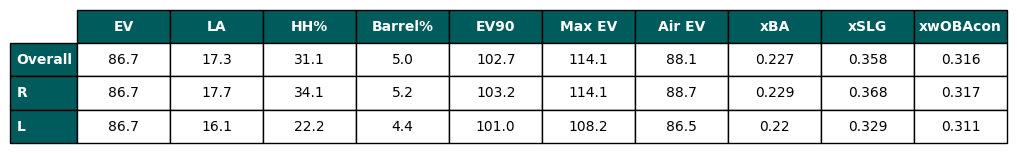

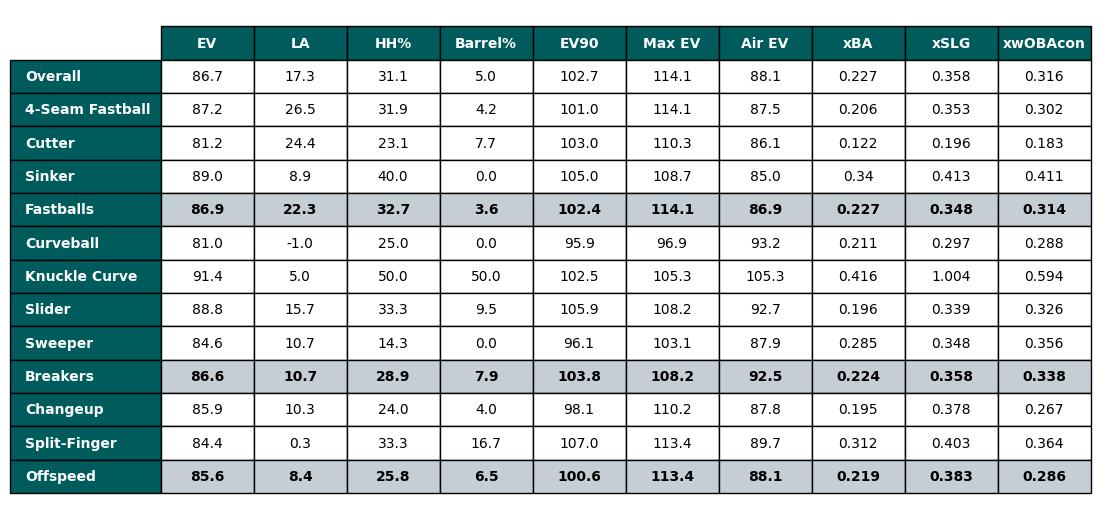

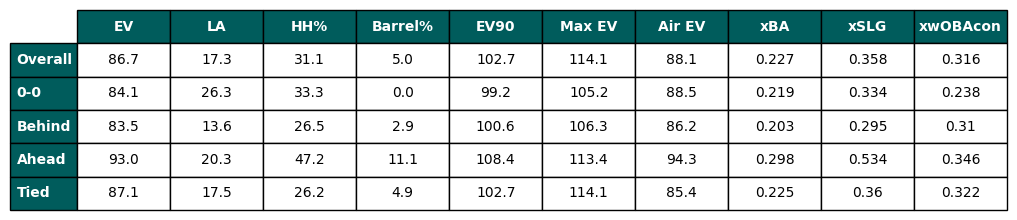

In [49]:
def build_split_table(df_bb, df_ab, df_pa, split_col, split_order, aggregates=None):
    rows = []
    valid_keys = []

    ev, la, hh, br, ev90, max_ev, air_ev = compute_batted_ball(df_bb)
    xBA, xSLG, xwOBA, xwOBAcon = compute_xstats(df_ab, df_pa, df_bb)

    hh = hh * 100 if hh is not None else None
    br = br * 100 if br is not None else None

    overall_row = [ev, la, hh, br, ev90, max_ev, air_ev, xBA, xSLG, xwOBAcon]
    overall_row_clean = [np.nan if v is None or pd.isna(v) else v for v in overall_row]
    rows.append(overall_row_clean)
    valid_keys.append("Overall")

    for key in split_order:
        if aggregates and key in aggregates:
            pitch_list = aggregates[key]
            bb_subset = df_bb[df_bb[split_col].isin(pitch_list)]
            ab_subset = df_ab[df_ab[split_col].isin(pitch_list)]
            pa_subset = df_pa[df_pa[split_col].isin(pitch_list)]
        else:
            bb_subset = df_bb[df_bb[split_col] == key]
            ab_subset = df_ab[df_ab[split_col] == key]
            pa_subset = df_pa[df_pa[split_col] == key]

        ev, la, hh, br, ev90, max_ev, air_ev = compute_batted_ball(bb_subset)
        xBA, xSLG, xwOBA, xwOBAcon = compute_xstats(ab_subset, pa_subset, bb_subset)

        hh = hh * 100 if hh is not None else None
        br = br * 100 if br is not None else None

        row = [ev, la, hh, br, ev90, max_ev, air_ev, xBA, xSLG, xwOBAcon]
        row_clean = [np.nan if v is None or pd.isna(v) else v for v in row]
        arr = np.array(row_clean, dtype=float)

        if not np.all(np.isnan(arr)):
            rows.append(row_clean)
            valid_keys.append(key)

    df_table = pd.DataFrame(rows, index=valid_keys,
                            columns=["EV", "LA", "HH%", "Barrel%", "EV90", "Max EV", "Air EV",
                                     "xBA", "xSLG", "xwOBAcon"])
    return df_table

def plot_table(df_table):
    if df_table.empty:
        print("No data to display.")
        return
    
    values = df_table.fillna(np.nan).astype(float).values
    
    values_rounded = np.hstack([
        np.round(values[:, :7], 1),
        np.round(values[:, 7:], 3)
    ])
    
    fig, ax = plt.subplots(figsize=(12, max(1.5, 0.5*len(df_table))))
    ax.axis('off')
    
    table = ax.table(cellText=values_rounded,
                     colLabels=df_table.columns,
                     rowLabels=df_table.index,
                     cellLoc='center',
                     loc='center')
    
    for key, cell in table.get_celld().items():
        row, col = key
        if row == 0 or col == -1:
            cell.set_facecolor("#005C5C") # Change Header Color Here
            cell.get_text().set_color("white")
            cell.get_text().set_fontweight('bold')
        
        if col >= 0 and row != 0:
            try:
                row_label = df_table.index[row - 1]
                if row_label in ["Fastballs", "Breakers", "Offspeed"]:
                    cell.set_facecolor("#C4CED4")
                    cell.get_text().set_fontweight('bold')
            except IndexError:
                continue

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    plt.show()


hand_order = ["R", "L"]
hand_table = build_split_table(bb, ab_pa, pa, "p_throws", hand_order)
plot_table(hand_table)

pitch_table = build_split_table(bb, ab_pa, pa, "pitch_name", existing_pitches, aggregates=aggregates)
plot_table(pitch_table)

count_order = ["0-0", "Behind", "Ahead", "Tied"]
count_table = build_split_table(bb, ab_pa, pa, "count_category", count_order)
plot_table(count_table)